# ECE.405.S21 Medical Image Analysis
### Assignment 02: Implementation of "Colour Retinal Image Enhancement based on Domain Knowledge" - ICVGIP 2008

- Name: Naren Akash R J
- Roll Number: 2018-111-020

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float

In [41]:
# image = cv2.imread('data/retina.JPG')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(image)
# plt.title('Input Image')
# plt.show()

In [42]:
# green_channel = image[:, :, 1]

# plt.imshow(green_channel, cmap='gray')
# plt.title('Input Image')
# plt.show()

In [43]:
# green_channel.shape

### Custom Image

In [44]:
# image = cv2.imread('images/fundus.jpeg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(image)
# plt.title('Input Image')
# plt.show()

### Testing Log-polar Transform on an External Image (Not Required)

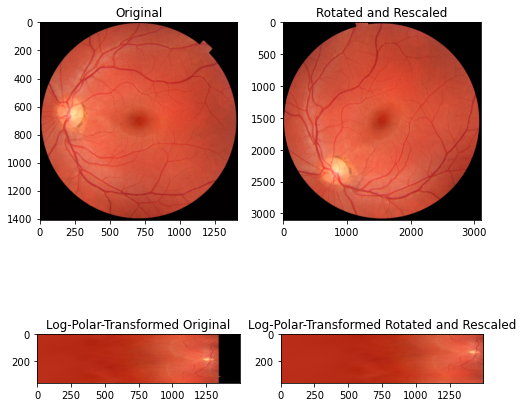

In [45]:
radius = 1500
angle = 53.7
scale = 2.2
image = data.retina()
# image = img_as_float(image)
rotated = rotate(image, angle)
rescaled = rescale(rotated, scale, multichannel=True)
image_polar = warp_polar(image, radius=radius,
                         scaling='log', multichannel=True)
rescaled_polar = warp_polar(rescaled, radius=radius,
                            scaling='log', multichannel=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original")
ax[0].imshow(image)
ax[1].set_title("Rotated and Rescaled")
ax[1].imshow(rescaled)
ax[2].set_title("Log-Polar-Transformed Original")
ax[2].imshow(image_polar)
ax[3].set_title("Log-Polar-Transformed Rotated and Rescaled")
ax[3].imshow(rescaled_polar)
plt.show()

255


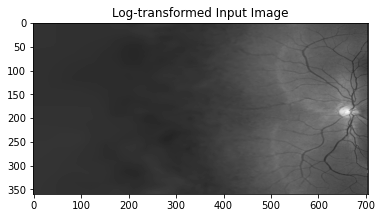

In [46]:
# image = green_channel
# image = data.retina()

image = cv2.imread('data/fundus.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# image = img_as_float(image)
print(np.max(image))
image = image[:, :, 1]
w, h = np.array(image.shape)[:2] / 2
# radius = np.sqrt(w ** 2 + h ** 2)
# radius = 705
radius = 280

# image_polar = warp_polar(img_as_float(image), radius=radius, scaling='log')
image_polar = warp_polar(image, radius=radius, scaling='log')
center = (np.array(image.shape)[:2] / 2) - 0.5
center = center.astype(int)
plt.imshow(image_polar, cmap='gray')
plt.title('Log-transformed Input Image')
plt.show()

In [47]:
image_polar.shape

(360, 705)

In [48]:
image.shape

(1411, 1411)

## Preparing for Non-Uniform Sampling

In [49]:
image_padded = np.pad(image, ((62, 62), (62, 62)), 'constant', constant_values=(0))
image_padded.shape

(1535, 1535)

In [50]:
center

array([705, 705])

In [86]:
minimum = 0
maximum = radius
exponent = 2.718
result = []

for i in np.linspace(0, 1, 5):
    result.append((1 - np.power(i, exponent)) * (maximum - minimum) + minimum)

In [87]:
mean = np.zeros_like(image)
std = np.zeros_like(image)

mask = np.zeros_like(image)

In [88]:
image.shape

(1411, 1411)

## Step 01: Computing Image Statistics in the Sampling Grid

In [89]:
# image_padded *= 255.0

X = []
Y = []
mean_list = []
std_list = []

for i in range(0, 360):
    for j in result:
        x = int(j * np.cos(np.radians(i))) + center[0]
        y = int(j * np.sin(np.radians(i))) + center[1]
        
        X.append(x)
        Y.append(y)
        
        mask[x][y] =  1

        mean[x][y] = np.mean(image_padded[x: x + 124, y: y + 124])
        std[x][y] = np.std(image_padded[x: x + 124, y: y + 124])
        
        mean_list.append(mean[x][y])
        std_list.append(std[x][y])

## Step 02: Interpolating the Image Statistics from Polar to Cartesian Grid

In [90]:
# Method 01: SciPy Interpolation Function

# from scipy import interpolate

# f_mean = interpolate.interp2d(X, Y, mean_list)
# f_std = interpolate.interp2d(X, Y, std_list)

In [91]:
# Method 02: Interpolation using griddata

from scipy.interpolate import griddata

xx = np.linspace(0, 1411,1411)
yy = np.linspace(0,1411,1411)
XX, YY = np.meshgrid(xx,yy)

# https://scipython.com/book/chapter-8-scipy/examples/two-dimensional-interpolation-with-scipyinterpolategriddata/

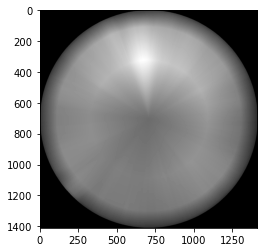

In [92]:
T_mean = griddata((X, Y), mean_list, (XX, YY), method='linear', fill_value=0)
plt.imshow(T_mean, cmap='gray')

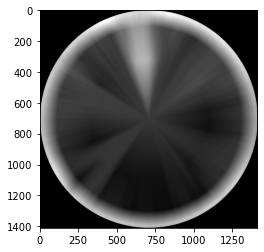

In [93]:
T_std = griddata((X, Y), std_list, (XX, YY), method='linear', fill_value=0)
plt.imshow(T_std, cmap='gray')

In [94]:
# For Method 01
# for i in range(mask.shape[0]):
#     for j in range(mask.shape[1]):
#         if mask[i][j] != 1:
#             mean[i][j] = f_mean(i, j)
#             std[i][j] == f_std(i, j)

In [95]:
mean = T_mean
std = T_std

## Step 03: Computing the Mahalanobis Distance.

In [96]:
# image_copy = image

# mahalanobis_distance = np.zeros(image_copy.shape)

# for i in range(image.shape[0]):
#     for j in range(image.shape[1]):
#         mahalanobis_distance[i][j] = np.absolute((image_copy[i][j] - mean[i][j]) / (std[i][j]))

In [97]:
image_copy = image
# image_copy *= 255.0

mahalanobis_distance = np.zeros(image_copy.shape)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        mahalanobis_distance[i][j] = np.absolute(float(image_copy[i, j] - mean[i, j]) / float(std[i, j] + 10e-7))
        
#         if std[i][j] != 0:
#             mahalanobis_distance[i][j] = np.absolute((image_copy[i][j] - mean[i][j]) / (std[i][j]) + 10e-7)
#         else:
#             mahalanobis_distance[i][j] = np.absolute((image_copy[i][j] - mean[i][j]) / (std[i][j]) + 10e-7)

In [98]:
print(np.sum(mahalanobis_distance <= 1), image.ravel().shape)

973933 (1990921,)


In [99]:
(image_copy[705][705] - mean[705][705]) / (std[705][705])

-1.305227969170768

In [100]:
print(np.min(mahalanobis_distance), np.max(mahalanobis_distance))

0.0 108000000.0


## Step 04: Extracting the Background Image

In [101]:
bg = np.zeros_like(image)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if mahalanobis_distance[i][j] <= 2:
            bg[i][j] = 255

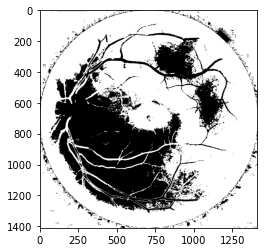

In [102]:
plt.imshow(bg, cmap='gray')

## Step 05: Computing the Background Image Statistics

In [103]:
bg_padded = np.pad(bg, ((12, 12), (12, 12)), 'constant', constant_values=(0))       

In [104]:
# np.sum(bg_padded < 0)

In [105]:
mean_bg = np.zeros(image.shape)
std_bg = np.zeros(image.shape)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        # runtime error occured when using bg_padded[][]
        mean_bg[i][j] = np.mean(bg_padded[i: i + 24, j: j + 24])
        std_bg[i][j] = np.std(bg_padded[i: i + 24, j: j + 24])

## Step 06: Estimating the True Image from the Degradation Components

In [106]:
image_new = np.zeros(image.shape)

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        image_new[i][j] = float(image_copy[i][j] - mean_bg[i][j]) / float(std_bg[i][j] + 10e-6)

image_new = image_new.astype(int)

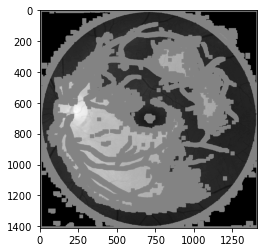

In [107]:
plt.imshow(image_new, cmap='gray')

## Step 07: Colour Retinal Image Enhancement

In [112]:
image_out = data.retina()
image_final = np.zeros(image_out.shape)

# image = cv2.imread('images/fundus.jpeg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# image = img_as_float(image)
m = np.max(image_out[:, :, :])

for i in range(image_out.shape[0]):
    for j in range(image_out.shape[1]):
        image_final[i, j, 0] = (image_new[i, j] * image_out[i, j, 0]) / (m + 10e-7)
        image_final[i, j, 1] = (image_new[i, j] * image_out[i, j, 1]) / (m + 10e-7)
        image_final[i, j, 2] = (image_new[i, j] * image_out[i, j, 2]) / (m + 10e-7)

# for i in range(image_out.shape[0]):
#     for j in range(image_out.shape[1]):
        
# for i in range(image_out.shape[0]):
#     for j in range(image_out.shape[1]):
        
# image[:, :, 0] = (image_new * image[:, :, 0]) / (np.max(image, axis=2) + 10e6)
# image[:, :, 1] = (image_new * image[:, :, 1]) / (np.max(image, axis=2) + 10e6)
# image[:, :, 2] = (image_new * image[:, :, 2]) / (np.max(image, axis=2) + 10e6)

In [119]:
np.max(image_new)

23599999

In [118]:
np.max(image_out[:, :, :])

255

## Display the Enhanced Colour Image

In [ ]:
plt.imshow(image_final)
plt.title('Output Image')
plt.show()

---
## Rough Work Ahead

In [ ]:
np.max(image_out[:, :, :]

In [121]:
np.max(std_bg)

127.5